In [1]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read and Data peek





In [22]:
train_df = pd.read_csv("/content/drive/MyDrive/subtaskA/mono_pred/train_monoling.csv")

In [23]:
dev_df = pd.read_csv("/content/drive/MyDrive/subtaskA/mono_pred/dev_monoling.csv")

In [24]:
train_df.shape,dev_df.shape

((119757, 5), (5000, 5))

In [25]:
train_df.head()

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4


In [26]:
dev_df.head()

,text,label,model,source,id
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow,0
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow,1
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow,2
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow,3
4,The following are some tips for becoming succe...,1,bloomz,wikihow,4


In [27]:
train_df['label'].value_counts(normalize=True)

0    0.528996
1    0.471004
Name: label, dtype: float64

In [28]:
dev_df['label'].value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

In [29]:
train_df['source'].unique()

array(['wikihow', 'wikipedia', 'reddit', 'arxiv', 'peerread'],
      dtype=object)

In [30]:
dev_df['source'].unique()

array(['wikihow', 'wikipedia', 'reddit', 'arxiv', 'peerread'],
      dtype=object)

In [31]:
train_df['model'].unique()

array(['chatGPT', 'cohere', 'davinci', 'dolly', 'human'], dtype=object)

In [32]:
dev_df['model'].unique()

array(['bloomz', 'human'], dtype=object)

In [33]:
train_df.groupby('model')['label'].value_counts()

model    label
chatGPT  1        14339
cohere   1        13678
davinci  1        14343
dolly    1        14046
human    0        63351
Name: label, dtype: int64

In [34]:
dev_df.groupby('model')['label'].value_counts()

model   label
bloomz  1        2500
human   0        2500
Name: label, dtype: int64

# Features and EDA

Feature Functions

In [35]:
def count_special_characters(text):

    return sum(not ch.isalnum() and not ch.isspace() for ch in text)


In [36]:
def cat_label_avg_feat(df_train, df_dev, group_column, new_column_name):

    cat_label_average_mapper = df_train.groupby(group_column)['label'].mean().to_dict()
    df_train[new_column_name] = df_train[group_column].map(cat_label_average_mapper)
    df_dev[new_column_name] = df_dev[group_column].map(cat_label_average_mapper)

    return df_train, df_dev

In [37]:
def Utest(df,df_name,group_col_name,cont_column_name):

  from scipy.stats import mannwhitneyu

  u_statistic, p_value = mannwhitneyu(
    df[df[group_col_name] == 0][cont_column_name],
    df[df[group_col_name] == 1][cont_column_name],
    alternative='two-sided'
  )
  print(f"{df_name:} {cont_column_name} Mann Whitney U test:")
  print("U-statistic:", u_statistic)
  print("P-value:", p_value)


# Features

1. Special Character

In [38]:
train_df['special_character_count'] = train_df['text'].apply(count_special_characters)
dev_df['special_character_count'] = dev_df['text'].apply(count_special_characters)

In [39]:
train_df['text_length'] = train_df['text'].apply(len)
dev_df['text_length'] = dev_df['text'].apply(len)

In [40]:
train_df['special_character_density'] = train_df['special_character_count'] / train_df['text_length']
dev_df['special_character_density'] = dev_df['special_character_count'] / dev_df['text_length']

In [42]:
train_df.head()

,text,label,model,source,id,special_character_count,text_length,special_character_density
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,2244,0.036542
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,3728,0.035408
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,157,5237,0.029979
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,4729,0.032142
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,3095,0.028756


Train data special char pattern

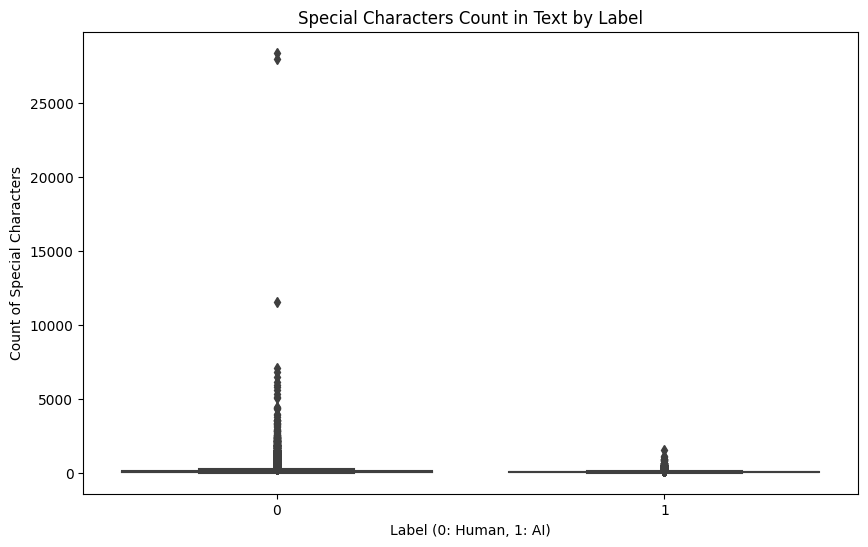

             count        mean         std  min   25%   50%    75%      max
label                                                                      
Human (0)  63351.0  112.025019  247.048026  0.0  36.0  60.0  122.0  28419.0
AI (1)     56406.0   49.706769   44.668844  0.0  26.0  38.0   56.0   1536.0


In [44]:
stats= train_df.groupby('label')['special_character_count'].describe().rename(index={0: 'Human (0)', 1: 'AI (1)'})

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='special_character_count', data=train_df)
plt.title('Special Characters Count in Text by Label')
plt.xlabel('Label (0: Human, 1: AI)')
plt.ylabel('Count of Special Characters')
plt.show()

print(stats)

<Axes: xlabel='special_character_count', ylabel='Count'>

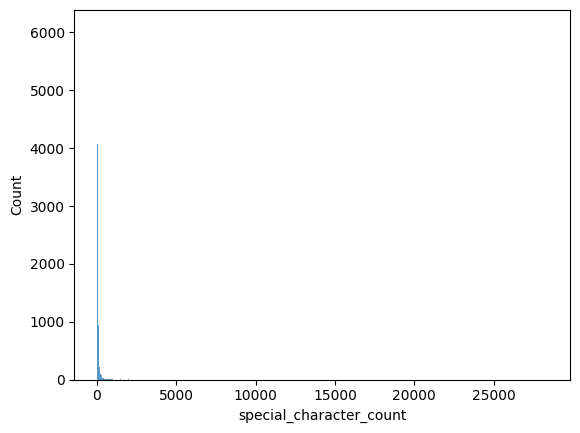

In [45]:
sns.histplot(train_df['special_character_count'])

In [47]:
# We need to check statistical diff between the use of special characters by human and ai.
# These are continous data and we see that it has a non normal or skewed distribution so we use Mann Whitney Utest
Utest(train_df,"Train","label","special_character_count")

Train special_character_count Mann Whitney U test:
U-statistic: 2450824331.5
P-value: 0.0


Binning Special Character Count column to convert it into categorical column

In [48]:
train_df['special_character_count'].describe()

count    119757.000000
mean         82.672888
std         184.914206
min           0.000000
25%          30.000000
50%          46.000000
75%          85.000000
max       28419.000000
Name: special_character_count, dtype: float64

In [50]:
bin_edges = [0, 10, 20, 30, 40, 50,60,70,float('inf')]
bin_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60' ,'61-70','others']

train_df['scc_binned'] = pd.cut(train_df['special_character_count'], bins=bin_edges, labels=bin_labels)
dev_df['scc_binned'] = pd.cut(dev_df['special_character_count'], bins=bin_edges, labels=bin_labels)

In [51]:
train_df['scc_binned'].value_counts(normalize=True)

others    0.309753
31-40     0.164697
21-30     0.161173
41-50     0.126291
51-60     0.083635
11-20     0.083409
61-70     0.057488
0-10      0.013554
Name: scc_binned, dtype: float64

In [52]:
dev_df['scc_binned'].value_counts(normalize=True)

others    0.222489
21-30     0.191277
11-20     0.177671
31-40     0.123449
41-50     0.099240
0-10      0.075230
51-60     0.066226
61-70     0.044418
Name: scc_binned, dtype: float64

## 2.1 Source Column

In [53]:
train_df.groupby('source')['label'].mean()

source
arxiv        0.436375
peerread     0.799079
reddit       0.436364
wikihow      0.436380
wikipedia    0.432158
Name: label, dtype: float64

In [54]:
dev_df.groupby('source')['label'].mean()

source
arxiv        0.5
peerread     0.5
reddit       0.5
wikihow      0.5
wikipedia    0.5
Name: label, dtype: float64

No discernable pattern

In [55]:
train_df.isna().sum()

text                          0
label                         0
model                         0
source                        0
id                            0
special_character_count       0
text_length                   0
special_character_density     0
scc_binned                   10
dtype: int64

## 2.2 Special Character Binned

In [56]:
train_df.groupby('scc_binned')['label'].mean()

scc_binned
0-10      0.702403
11-20     0.696436
21-30     0.606684
31-40     0.572254
41-50     0.541229
51-60     0.473689
61-70     0.412841
others    0.257198
Name: label, dtype: float64

In [57]:
dev_df.groupby('scc_binned')['label'].mean()

scc_binned
0-10      0.734043
11-20     0.818694
21-30     0.665272
31-40     0.529984
41-50     0.413306
51-60     0.371601
61-70     0.324324
others    0.120504
Name: label, dtype: float64

Distribution is close

In [58]:
train_df, dev_df = cat_label_avg_feat(
    df_train=train_df,
    df_dev=dev_df,
    group_column='scc_binned',
    new_column_name='scc_bin_label_avg'
)

In [59]:
train_df.isna().sum()

text                          0
label                         0
model                         0
source                        0
id                            0
special_character_count       0
text_length                   0
special_character_density     0
scc_binned                   10
scc_bin_label_avg            10
dtype: int64

feature has null values which need to be filled

In [61]:
train_df[train_df['scc_bin_label_avg'].isna()==True]['special_character_count'].unique()

array([0])

feture is null where special character count is 0. So we impute feature value with 0

In [62]:
train_df.dtypes

text                           object
label                           int64
model                          object
source                         object
id                              int64
special_character_count         int64
text_length                     int64
special_character_density     float64
scc_binned                   category
scc_bin_label_avg            category
dtype: object

In [63]:
train_df['scc_bin_label_avg']=train_df['scc_bin_label_avg'].astype('float')
dev_df['scc_bin_label_avg']=dev_df['scc_bin_label_avg'].astype('float')

In [64]:
train_df['scc_bin_label_avg'].fillna(0.0,inplace=True)
dev_df['scc_bin_label_avg'].fillna(0.0,inplace=True)

## 2.3 Text length Binned

In [65]:
train_df.groupby(['label'])['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,63351.0,3547.266010,5319.834821,10.0,1285.0,1804.0,3724.0,198470.0
1,56406.0,1931.031663,1108.084847,42.0,1230.0,1648.0,2234.0,14807.0


In [66]:
Utest(train_df,"Train","label","text_length")

Train text_length Mann Whitney U test:
U-statistic: 2109372697.0
P-value: 0.0


In [67]:
train_df['text_length'].describe()

count    119757.000000
mean       2786.013519
std        4024.922554
min          10.000000
25%        1262.000000
50%        1712.000000
75%        2742.000000
max      198470.000000
Name: text_length, dtype: float64

In [68]:
bin_edges = [0, 900, 1000, 2000, 3000,float('inf')]
bin_labels = ['0-900', '901-1000', '1001-2000', '2001-3000', 'others']

train_df['tl_binned'] = pd.cut(train_df['text_length'], bins=bin_edges, labels=bin_labels)
dev_df['tl_binned'] = pd.cut(dev_df['text_length'], bins=bin_edges, labels=bin_labels)

Bin data distribution

In [69]:
train_df['tl_binned'].value_counts(normalize=True)

1001-2000    0.550757
others       0.221123
2001-3000    0.168124
0-900        0.042945
901-1000     0.017051
Name: tl_binned, dtype: float64

Avg AI per bin

In [71]:
train_df.groupby('tl_binned')['label'].mean()

tl_binned
0-900        0.828894
901-1000     0.921156
1001-2000    0.481359
2001-3000    0.574849
others       0.262037
Name: label, dtype: float64

Creating the feature

In [72]:
train_df, dev_df = cat_label_avg_feat(
    df_train=train_df,
    df_dev=dev_df,
    group_column='tl_binned',
    new_column_name='tl_bin_label_avg'
)

In [73]:
train_df.dtypes

text                           object
label                           int64
model                          object
source                         object
id                              int64
special_character_count         int64
text_length                     int64
special_character_density     float64
scc_binned                   category
scc_bin_label_avg             float64
tl_binned                    category
tl_bin_label_avg             category
dtype: object

In [74]:
train_df['tl_bin_label_avg']=train_df['tl_bin_label_avg'].astype('float')
dev_df['tl_bin_label_avg']=dev_df['tl_bin_label_avg'].astype('float')

In [75]:
train_df.isna().sum()

text                          0
label                         0
model                         0
source                        0
id                            0
special_character_count       0
text_length                   0
special_character_density     0
scc_binned                   10
scc_bin_label_avg             0
tl_binned                     0
tl_bin_label_avg              0
dtype: int64

In [76]:
dev_df.isna().sum()

text                         0
label                        0
model                        0
source                       0
id                           0
special_character_count      0
text_length                  0
special_character_density    0
scc_binned                   2
scc_bin_label_avg            0
tl_binned                    0
tl_bin_label_avg             0
dtype: int64

In [77]:
train_df.head()

,text,label,model,source,id,special_character_count,text_length,special_character_density,scc_binned,scc_bin_label_avg,tl_binned,tl_bin_label_avg
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,2244,0.036542,others,0.257198,2001-3000,0.574849
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,3728,0.035408,others,0.257198,others,0.262037
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,157,5237,0.029979,others,0.257198,others,0.262037
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,4729,0.032142,others,0.257198,others,0.262037
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,3095,0.028756,others,0.257198,others,0.262037


In [78]:
train_df.columns

Index(['text', 'label', 'model', 'source', 'id', 'special_character_count',
       'text_length', 'special_character_density', 'scc_binned',
       'scc_bin_label_avg', 'tl_binned', 'tl_bin_label_avg'],
      dtype='object')

# Correlation of features with output column

In [79]:
corr_feature=['label','special_character_count','text_length', 'special_character_density',
              'scc_bin_label_avg','tl_bin_label_avg']

#corr_feature=[,'Special_Characters_Count',
 #      'Text_Length', 'Special_Characters_Ratio', 'word_count',
  #     'sentence_count', 'scc_binned', 'wc_binned', 'sc_binned',
   #    'wc_bin_label_avg', 'sc_bin_label_avg', 'scc_bin_label_avg',
    #   'tl_binned', 'tl_bin_label_avg']

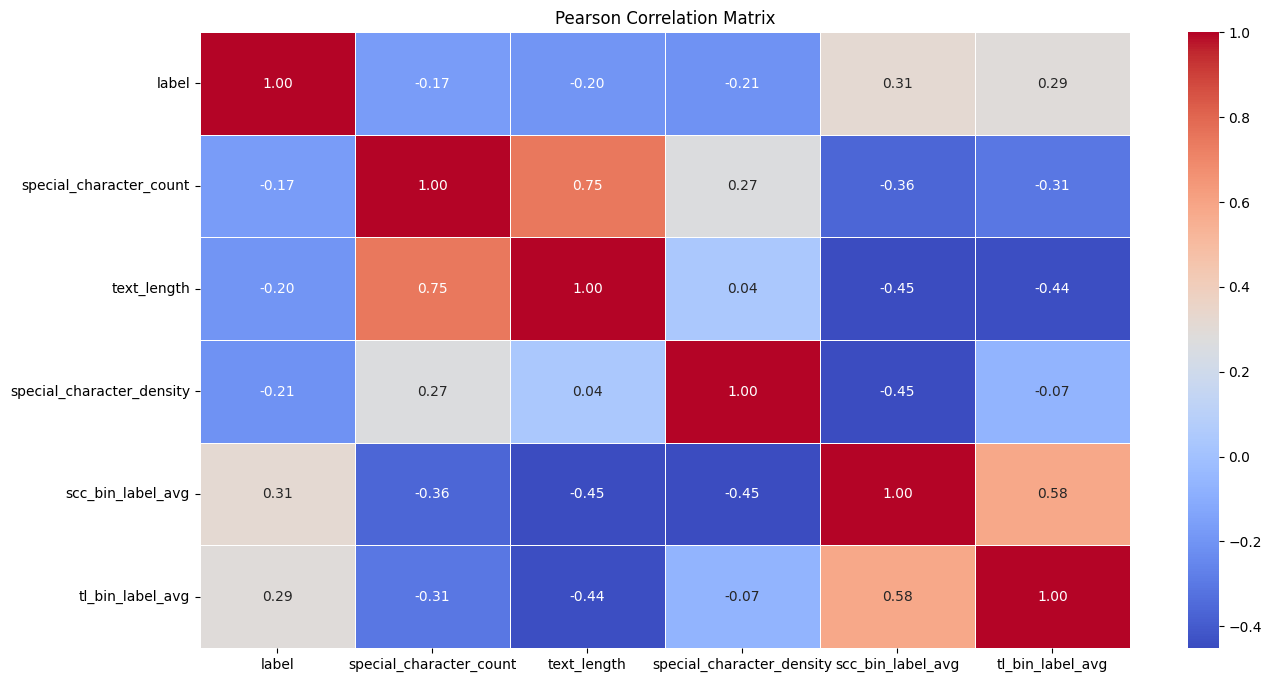

In [80]:
correlation_matrix = train_df[corr_feature].corr(method='pearson')

# Use seaborn to create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

# Internediate model 1- Random Forest Classifier with structural features

In [82]:
feature=['special_character_count','text_length',
         'special_character_density','scc_bin_label_avg','tl_bin_label_avg']
len(feature)

5

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = train_df[feature]
y_train = train_df['label']


X_dev = dev_df[feature]
y_dev = dev_df['label']


rfc = RandomForestClassifier(max_depth=3,n_estimators=500, random_state=42)

rfc.fit(X_train, y_train)


y_pred = rfc.predict(X_dev)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.7244
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      2500
           1       0.71      0.75      0.73      2500

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [84]:
from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(dev_df['label'],y_pred))

[[1755  745]
 [ 633 1867]]


Feature ranking:
3. special_character_density (0.34912287312830836)
1. special_character_count (0.23041907661904654)
2. text_length (0.20347751146052573)
4. scc_bin_label_avg (0.11648916842247829)
5. tl_bin_label_avg (0.10049137036964106)


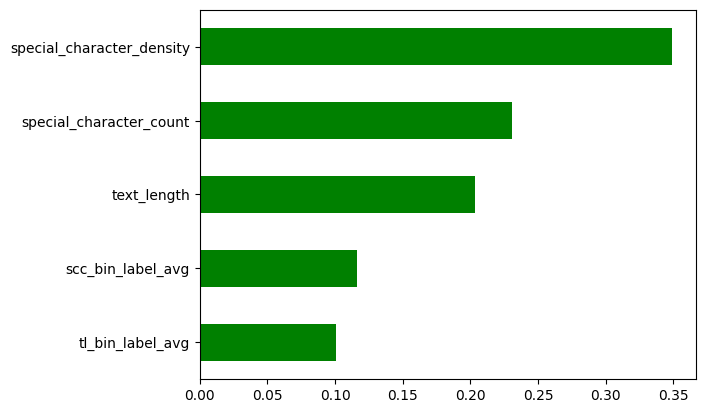

In [85]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=train_df[feature].columns)
feat_importances.nsmallest(len(feature)).plot(kind='barh',color='g')
plt.show()


# Incorporating truncated text tokens using BERT





In [86]:
import pickle

with open('/content/drive/MyDrive/subtaskA/mono_pred/train_embeddings512.pkl', 'rb') as file:
    train_embeddings = pickle.load(file)

In [87]:
train_df['embeddings'] = train_embeddings[:len(train_df)]

In [88]:
with open('/content/drive/MyDrive/subtaskA/mono_pred/dev_embeddings512.pkl', 'rb') as file:
    dev_embeddings = pickle.load(file)

In [89]:
dev_df['embeddings'] = dev_embeddings[:len(dev_df)]

In [90]:
len(train_df.loc[0,'embeddings'])

768

In [91]:
#train_df.loc[0,'embeddings']

# Incorporating T5 based features



In [92]:
with open('/content/drive/MyDrive/subtaskA/mono_pred/train-features-t5-small.pkl', 'rb') as file:
    train_t5 = pickle.load(file)

In [93]:
with open('/content/drive/MyDrive/subtaskA/mono_pred/dev-features-t5-small.pkl', 'rb') as file:
    dev_t5 = pickle.load(file)

In [95]:
sum_logprobs = [row[-10] for row in train_t5]
meanp = [row[-6] for row in train_t5]
stdp = [row[-5] for row in train_t5]
entropyp = [row[-4] for row in train_t5]
kurtosisp = [row[-3] for row in train_t5]
skewnessp = [row[-2] for row in train_t5]
perplexity = [row[-1] for row in train_t5]

In [96]:
train_df['sum_logprobs']=sum_logprobs
train_df['meanp']=meanp
train_df['stdp']=stdp
train_df['entropyp']=entropyp
train_df['kurtosisp']=kurtosisp
train_df['skewnessp']=skewnessp
train_df['perplexity']=perplexity

In [97]:
sum_logprobs = [row[-10] for row in dev_t5]
meanp = [row[-6] for row in dev_t5]
stdp = [row[-5] for row in dev_t5]
entropyp = [row[-4] for row in dev_t5]
kurtosisp = [row[-3] for row in dev_t5]
skewnessp = [row[-2] for row in dev_t5]
perplexity = [row[-1] for row in dev_t5]

In [98]:
dev_df['sum_logprobs']=sum_logprobs
dev_df['meanp']=meanp
dev_df['stdp']=stdp
dev_df['entropyp']=entropyp
dev_df['kurtosisp']=kurtosisp
dev_df['skewnessp']=skewnessp
dev_df['perplexity']=perplexity

## Creating sum features of embedding

In [99]:
train_df['embedding_sum'] = train_df['embeddings'].apply(lambda x: np.sum(x))
dev_df['embedding_sum'] = dev_df['embeddings'].apply(lambda x: np.sum(x))

In [100]:
train_df['embedding_sum'].describe()

count    119757.000000
mean         -9.982048
std           1.308435
min         -16.427170
25%         -10.806076
50%          -9.872453
75%          -9.048218
max          -5.111742
Name: embedding_sum, dtype: float64

In [101]:
train_df.head()

,text,label,model,source,id,special_character_count,text_length,special_character_density,scc_binned,scc_bin_label_avg,...,tl_bin_label_avg,embeddings,sum_logprobs,meanp,stdp,entropyp,kurtosisp,skewnessp,perplexity,embedding_sum
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,2244,0.036542,others,0.257198,...,0.574849,"[-0.5115177035331726, -1.0300289392471313, 0.5...",-7708.853212,-15.056354,8.754502,4.706275,2.229271,0.788372,3.458529e+06,-10.508572
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,3728,0.035408,others,0.257198,...,0.262037,"[-0.6144890785217285, -0.841050386428833, 0.17...",-10679.249287,-20.857909,5.017419,0.464113,3.748940,0.743565,1.144128e+09,-12.353274
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,157,5237,0.029979,others,0.257198,...,0.262037,"[-0.5282367467880249, -0.8618617057800293, 0.1...",-10664.481550,-20.829066,5.346147,1.149490,4.092596,0.918128,1.111599e+09,-12.034767
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,4729,0.032142,others,0.257198,...,0.262037,"[-0.41474711894989014, -0.5633561611175537, 0....",-10939.190513,-21.365606,5.270202,1.395906,4.018196,0.581320,1.900925e+09,-11.067939
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,3095,0.028756,others,0.257198,...,0.262037,"[0.008139261975884438, -0.6293084621429443, -0...",-10731.163978,-20.959305,5.050144,0.400308,4.252442,0.791794,1.266223e+09,-10.193344


# Embedding in modelling

In [104]:
train_df.columns

Index(['text', 'label', 'model', 'source', 'id', 'special_character_count',
       'text_length', 'special_character_density', 'scc_binned',
       'scc_bin_label_avg', 'tl_binned', 'tl_bin_label_avg', 'embeddings',
       'sum_logprobs', 'meanp', 'stdp', 'entropyp', 'kurtosisp', 'skewnessp',
       'perplexity', 'embedding_sum'],
      dtype='object')

In [105]:
train_df.dtypes

text                           object
label                           int64
model                          object
source                         object
id                              int64
special_character_count         int64
text_length                     int64
special_character_density     float64
scc_binned                   category
scc_bin_label_avg             float64
tl_binned                    category
tl_bin_label_avg              float64
embeddings                     object
sum_logprobs                  float64
meanp                         float64
stdp                          float64
entropyp                      float64
kurtosisp                     float64
skewnessp                     float64
perplexity                    float64
embedding_sum                 float64
dtype: object

In [108]:
corr_feature=['label','special_character_count','text_length', 'special_character_density',
              'scc_bin_label_avg','tl_bin_label_avg','embedding_sum']

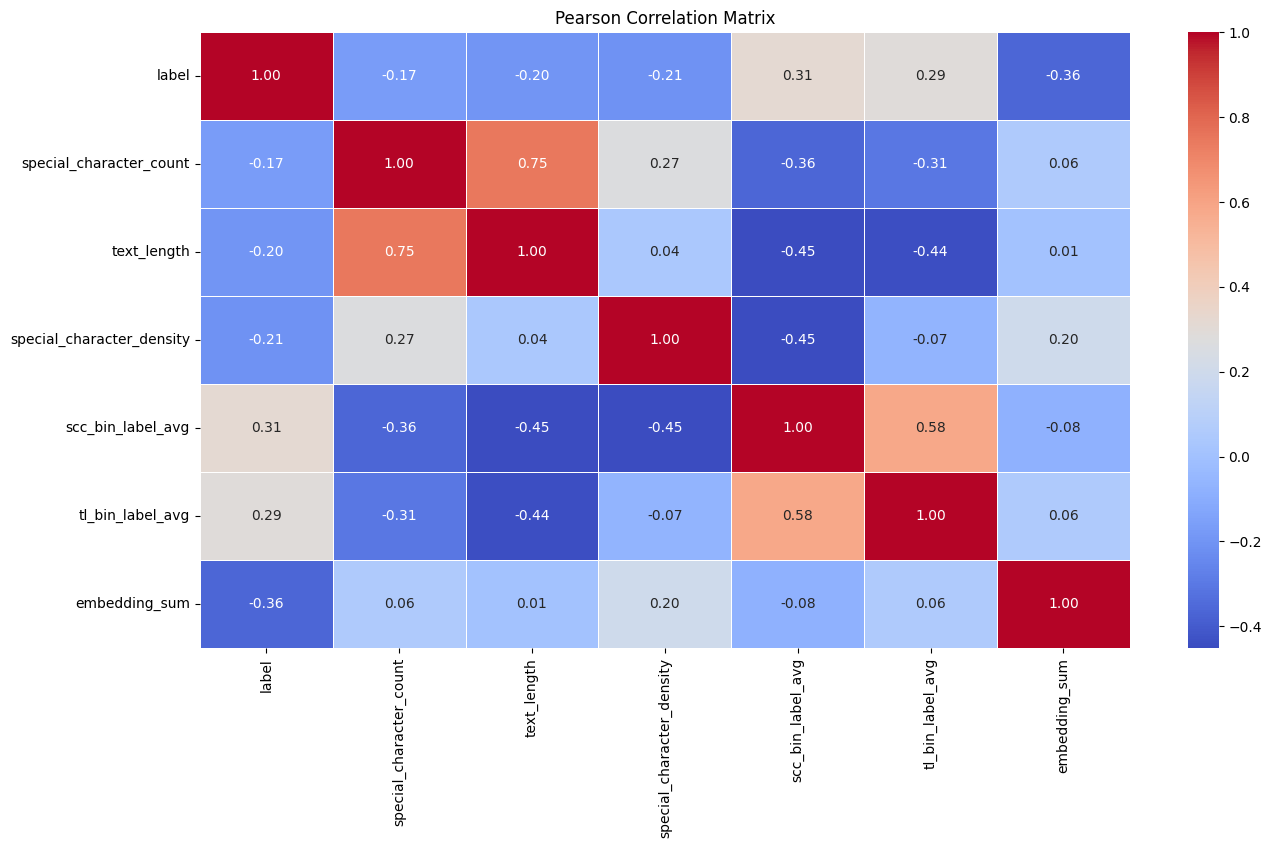

In [109]:
correlation_matrix = train_df[corr_feature].corr(method='pearson')

# Use seaborn to create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

In [110]:
dev_df.columns

Index(['text', 'label', 'model', 'source', 'id', 'special_character_count',
       'text_length', 'special_character_density', 'scc_binned',
       'scc_bin_label_avg', 'tl_binned', 'tl_bin_label_avg', 'embeddings',
       'sum_logprobs', 'meanp', 'stdp', 'entropyp', 'kurtosisp', 'skewnessp',
       'perplexity', 'embedding_sum'],
      dtype='object')

## Intermediate Model 2: RFC with embedding sum

In [113]:
feature=['special_character_count','text_length', 'special_character_density',
              'scc_bin_label_avg','tl_bin_label_avg','embedding_sum']


len(feature)

6

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = train_df[feature]
y_train = train_df['label']


X_dev = dev_df[feature]
y_dev = dev_df['label']


rfc = RandomForestClassifier(max_depth=3,n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_dev)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.7226
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2500
           1       0.72      0.72      0.72      2500

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [115]:
from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(dev_df['label'],y_pred))

[[1810  690]
 [ 697 1803]]


Feature ranking:
6. embedding_sum (0.2791974369264041)
1. special_character_count (0.18900778915608338)
2. text_length (0.17252125316297906)
3. special_character_density (0.1692908557089889)
4. scc_bin_label_avg (0.10323121481472695)
5. tl_bin_label_avg (0.08675145023081765)


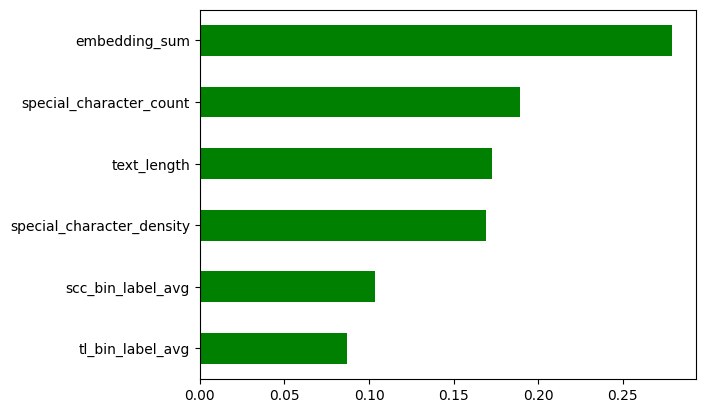

In [116]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=train_df[feature].columns)
feat_importances.nsmallest(len(feature)).plot(kind='barh',color='g')
plt.show()

In [117]:
#feature=['Special_Characters_Count',
#       'Text_Length', 'Special_Characters_Ratio', 'word_count',
#       'sentence_count',
#       'wc_bin_label_avg', 'sc_bin_label_avg', 'scc_bin_label_avg',
#        'tl_bin_label_avg',
#       'embedding_sum']

feature=['special_character_count','text_length', 'special_character_density',
              'scc_bin_label_avg','tl_bin_label_avg','embedding_sum']


# Selecting important embedding dimensions only using Tree importance

In [118]:
train_embeddings_df = pd.DataFrame(train_embeddings)

embedding_column_names = ['em' + str(i+1) for i in range(train_embeddings_df.shape[1])]
train_embeddings_df.columns = embedding_column_names

X_train = pd.concat([train_df[feature], train_embeddings_df], axis=1)

In [119]:
dev_embeddings_df = pd.DataFrame(dev_embeddings)

embedding_column_names = ['em' + str(i+1) for i in range(dev_embeddings_df.shape[1])]
dev_embeddings_df.columns = embedding_column_names

X_dev = pd.concat([dev_df[feature], dev_embeddings_df], axis=1)

In [121]:
X_train.head()

,special_character_count,text_length,special_character_density,scc_bin_label_avg,tl_bin_label_avg,embedding_sum,em1,em2,em3,em4,...,em759,em760,em761,em762,em763,em764,em765,em766,em767,em768
0,82,2244,0.036542,0.257198,0.574849,-10.508572,-0.511518,-1.030029,0.516741,0.146015,...,0.135471,-0.576481,-0.113121,-0.152966,0.439154,1.009276,-0.204999,-0.032524,0.107763,0.251620
1,132,3728,0.035408,0.257198,0.262037,-12.353274,-0.614489,-0.841050,0.171994,0.062418,...,0.236045,-1.032025,0.154932,-0.340842,0.638348,1.140460,0.244510,0.083710,0.296018,0.271299
2,157,5237,0.029979,0.257198,0.262037,-12.034767,-0.528237,-0.861862,0.165501,-0.055782,...,0.660410,-0.637341,0.077974,-0.391543,0.068592,1.093372,0.040459,-0.103604,0.047477,0.373491
3,152,4729,0.032142,0.257198,0.262037,-11.067939,-0.414747,-0.563356,0.006863,0.411556,...,0.349561,-1.049430,0.100585,-0.168791,0.295156,0.843476,-0.030488,0.056761,-0.314334,0.442807
4,89,3095,0.028756,0.257198,0.262037,-10.193344,0.008139,-0.629308,-0.155384,0.240225,...,0.076895,-1.201068,-0.002092,-0.530576,0.080040,0.870245,0.048050,-0.003138,0.111683,0.275417


# Intermediate model 3: RFC model to find important embedding dimensions

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

y_train = train_df['label']
y_dev = dev_df['label']


rfc = RandomForestClassifier(max_depth=3,n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_dev)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.5344
              precision    recall  f1-score   support

           0       0.52      0.94      0.67      2500
           1       0.67      0.13      0.22      2500

    accuracy                           0.53      5000
   macro avg       0.60      0.53      0.45      5000
weighted avg       0.60      0.53      0.45      5000



In [123]:
importance = rfc.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance})
non_zero_importances = feature_importances[feature_importances['importance'] > 0]

In [124]:
non_zero_importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
492,em487,0.042733
635,em630,0.038259
5,embedding_sum,0.038031
240,em235,0.036166
147,em142,0.032857
29,em24,0.029285
69,em64,0.028723
245,em240,0.028606
587,em582,0.026854
170,em165,0.025411


In [125]:
train_df.head()

,text,label,model,source,id,special_character_count,text_length,special_character_density,scc_binned,scc_bin_label_avg,...,tl_bin_label_avg,embeddings,sum_logprobs,meanp,stdp,entropyp,kurtosisp,skewnessp,perplexity,embedding_sum
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,2244,0.036542,others,0.257198,...,0.574849,"[-0.5115177035331726, -1.0300289392471313, 0.5...",-7708.853212,-15.056354,8.754502,4.706275,2.229271,0.788372,3.458529e+06,-10.508572
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,3728,0.035408,others,0.257198,...,0.262037,"[-0.6144890785217285, -0.841050386428833, 0.17...",-10679.249287,-20.857909,5.017419,0.464113,3.748940,0.743565,1.144128e+09,-12.353274
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,157,5237,0.029979,others,0.257198,...,0.262037,"[-0.5282367467880249, -0.8618617057800293, 0.1...",-10664.481550,-20.829066,5.346147,1.149490,4.092596,0.918128,1.111599e+09,-12.034767
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,4729,0.032142,others,0.257198,...,0.262037,"[-0.41474711894989014, -0.5633561611175537, 0....",-10939.190513,-21.365606,5.270202,1.395906,4.018196,0.581320,1.900925e+09,-11.067939
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,3095,0.028756,others,0.257198,...,0.262037,"[0.008139261975884438, -0.6293084621429443, -0...",-10731.163978,-20.959305,5.050144,0.400308,4.252442,0.791794,1.266223e+09,-10.193344


# Using top 20 features

In [128]:
feature=['em487',
 'em630',
 'embedding_sum',
 'em235',
 'em142',
 'em24',
 'em64',
 'em240',
 'em582',
 'em165',
 'em594',
 'scc_bin_label_avg',
 'em374',
 'em188',
 'em584',
 'em14',
 'em206',
 'special_character_count',
 'em261',
 'em309']

In [129]:
X_train_mini = X_train[feature]
y_train = train_df['label']

X_dev_mini = X_dev[feature]
y_dev = dev_df['label']

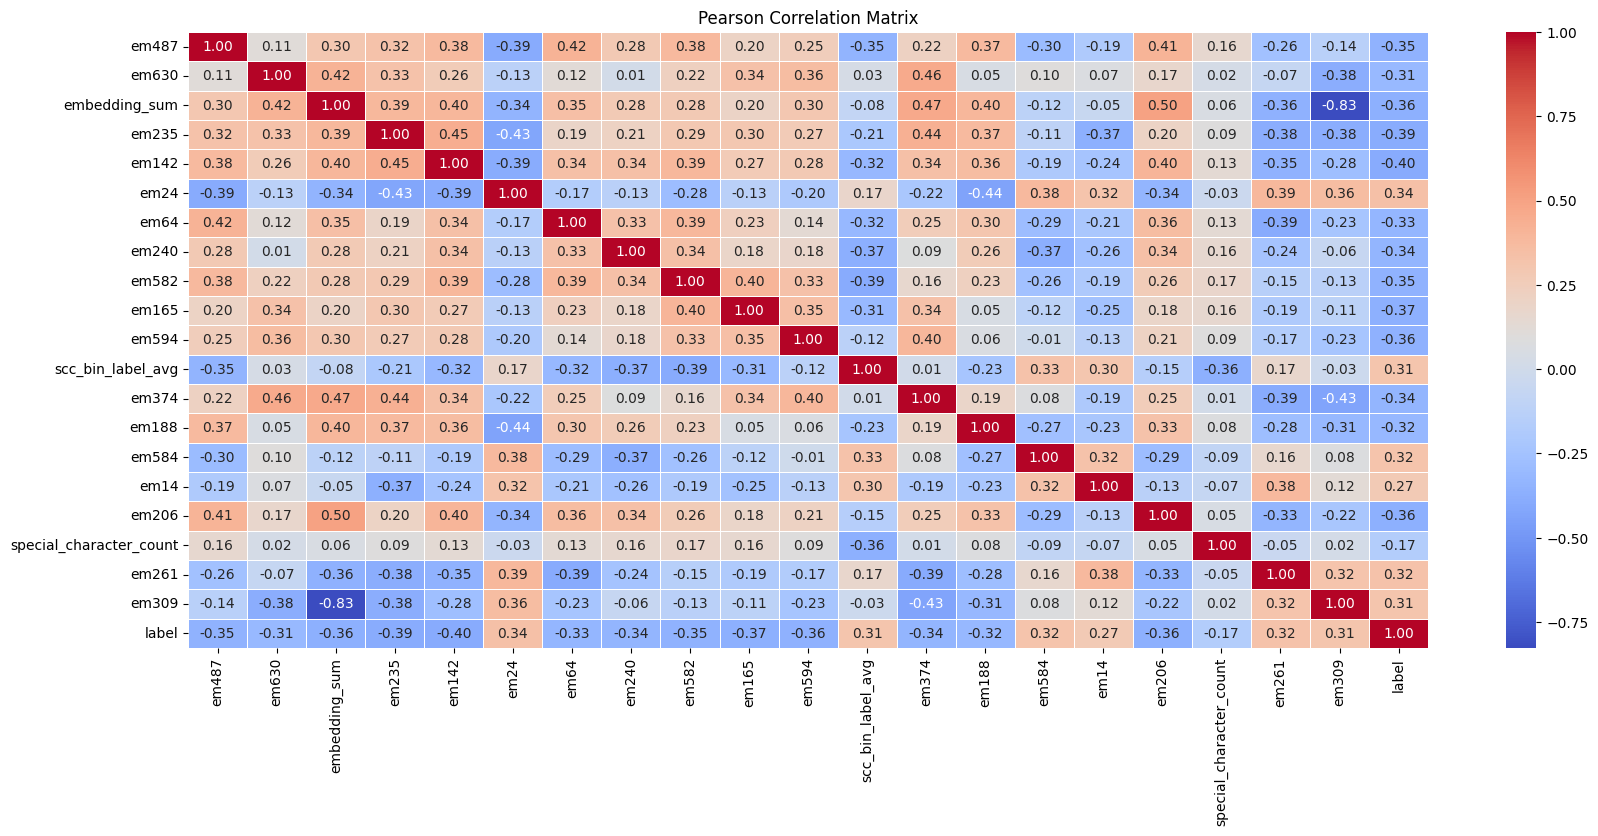

In [130]:
X_train_mini_with_label = X_train_mini.copy()
X_train_mini_with_label['label'] = y_train
correlation_matrix = X_train_mini_with_label.corr(method='pearson')

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

# Intermediate Model 4: RFC with top 20 features

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(max_depth=3,n_estimators=100, random_state=42)

rfc.fit(X_train_mini, y_train)

y_pred = rfc.predict(X_dev_mini)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.5268
              precision    recall  f1-score   support

           0       0.52      0.91      0.66      2500
           1       0.62      0.14      0.23      2500

    accuracy                           0.53      5000
   macro avg       0.57      0.53      0.44      5000
weighted avg       0.57      0.53      0.44      5000



In [132]:
from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(dev_df['label'],y_pred))

[[2278  222]
 [2144  356]]


Feature ranking:
4. em235 (0.12579096304387996)
5. em142 (0.09594752141134849)
11. em594 (0.08553723476798461)
6. em24 (0.08396776509610272)
3. embedding_sum (0.07242421364119515)
15. em584 (0.06832921767130212)
10. em165 (0.067683791552094)
17. em206 (0.06454893964029552)
8. em240 (0.04621889605853981)
12. scc_bin_label_avg (0.04597728522214899)
9. em582 (0.038718101697524196)
18. special_character_count (0.03461940592405937)
1. em487 (0.033806226591647816)
13. em374 (0.030161157218141884)
19. em261 (0.02890036918515363)
7. em64 (0.02848617046184408)
2. em630 (0.01820179859142118)
20. em309 (0.016284677477556037)
16. em14 (0.008100888296761057)
14. em188 (0.006295376450999544)


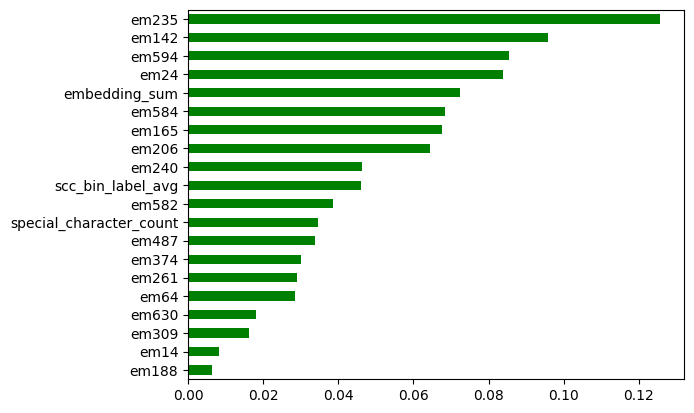

In [133]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=X_train[feature].columns)
feat_importances.nsmallest(len(feature)).plot(kind='barh',color='g')
plt.show()

Removing bottom 8 features

# Intermediate Model 5: RFC with top 12 features

In [138]:
feature=[
 'embedding_sum',
 'em235',
 'em142',
 'em24',
 'em240',
 'em582',
 'em165',
 'em594',
 'scc_bin_label_avg',
 'em584',
 'em206',
 'special_character_count'
          ]
len(feature)

12

In [139]:
X_train_mini = X_train[feature]
y_train = train_df['label']

X_dev_mini = X_dev[feature]
y_dev = dev_df['label']

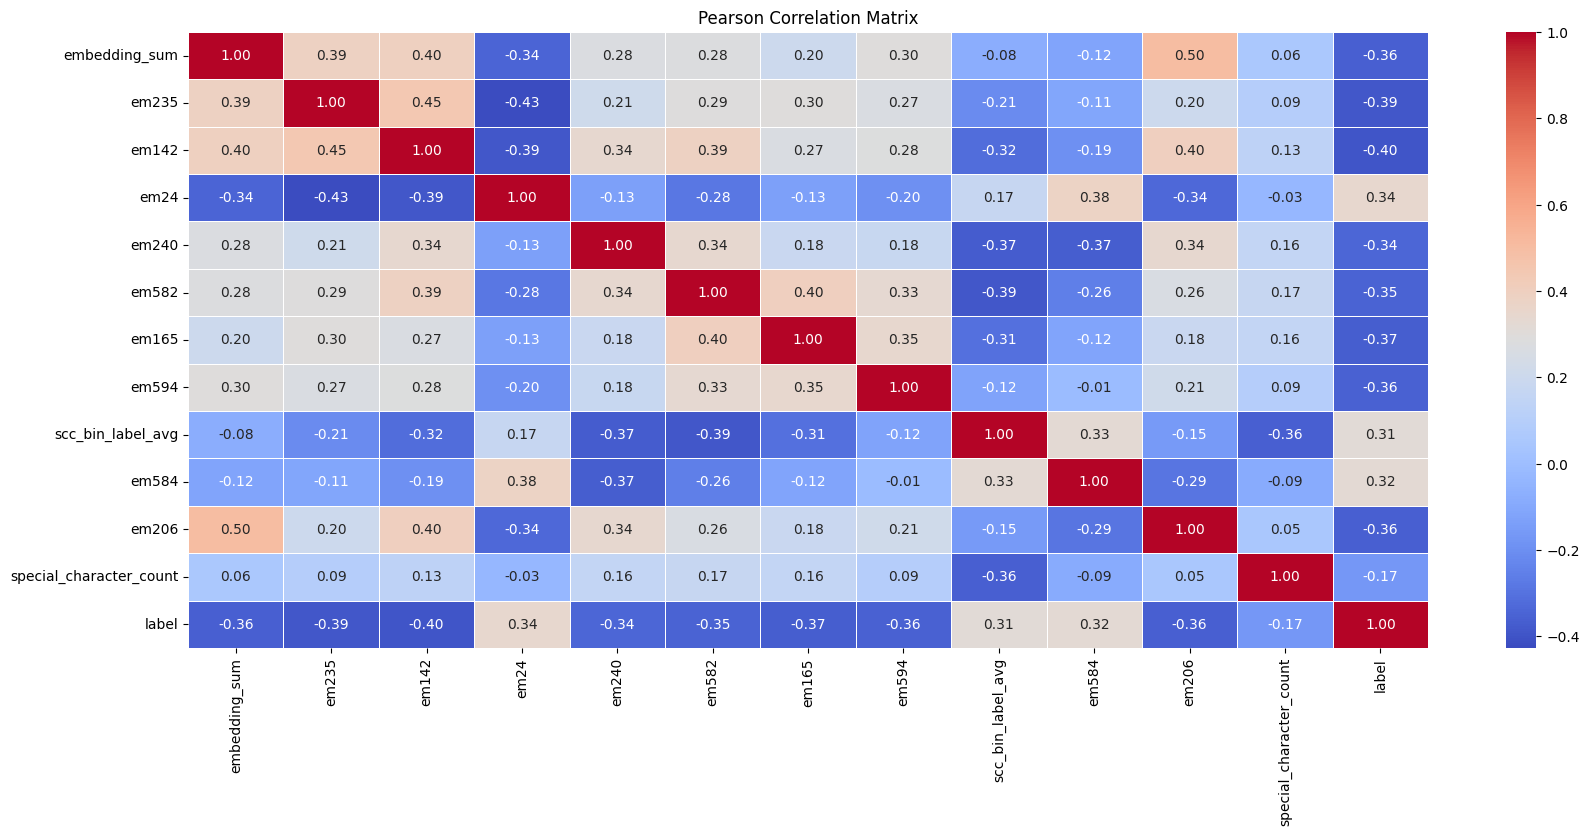

In [140]:
X_train_mini_with_label = X_train_mini.copy()
X_train_mini_with_label['label'] = y_train
correlation_matrix = X_train_mini_with_label.corr(method='pearson')

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(max_depth=3,n_estimators=100, random_state=42)

rfc.fit(X_train_mini, y_train)

y_pred = rfc.predict(X_dev_mini)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.5338
              precision    recall  f1-score   support

           0       0.52      0.89      0.66      2500
           1       0.62      0.17      0.27      2500

    accuracy                           0.53      5000
   macro avg       0.57      0.53      0.46      5000
weighted avg       0.57      0.53      0.46      5000



Feature ranking:
2. em235 (0.17743592523373447)
3. em142 (0.16273450011833132)
8. em594 (0.11109273073336447)
7. em165 (0.0742042825213275)
5. em240 (0.07175477031695743)
10. em584 (0.07055093218196136)
12. special_character_count (0.06820310455439715)
1. embedding_sum (0.06470396475454551)
4. em24 (0.059206468835969105)
11. em206 (0.05645338663154752)
6. em582 (0.0452219989744163)
9. scc_bin_label_avg (0.0384379351434479)


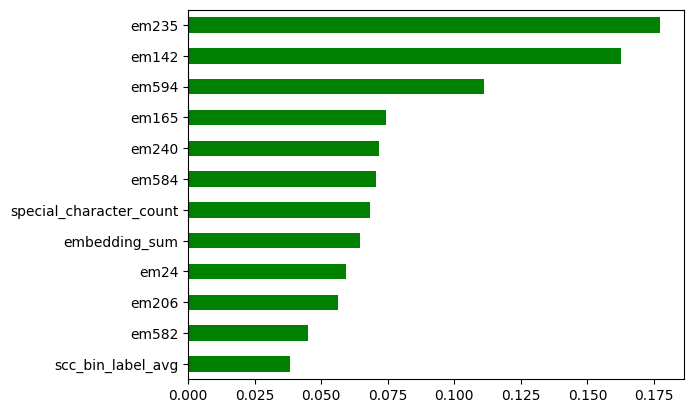

In [142]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=X_train[feature].columns)
feat_importances.nsmallest(len(feature)).plot(kind='barh',color='g')
plt.show()

# Intermediate Model 5: RFC with with embedding and structural features

Combining Embedding feature which is predicting Human text better and structral features which is predicting AI text better

In [145]:
feature=[
 'embedding_sum',
 'em235',
 'em142',
 'em165',
 'em594',
 'scc_bin_label_avg',
 'special_character_count',
"text_length",
"special_character_density",
"tl_bin_label_avg" ,
          ]


len(feature)

10

In [146]:
X_train_mini = X_train[feature]
y_train = train_df['label']

X_dev_mini = X_dev[feature]
y_dev = dev_df['label']

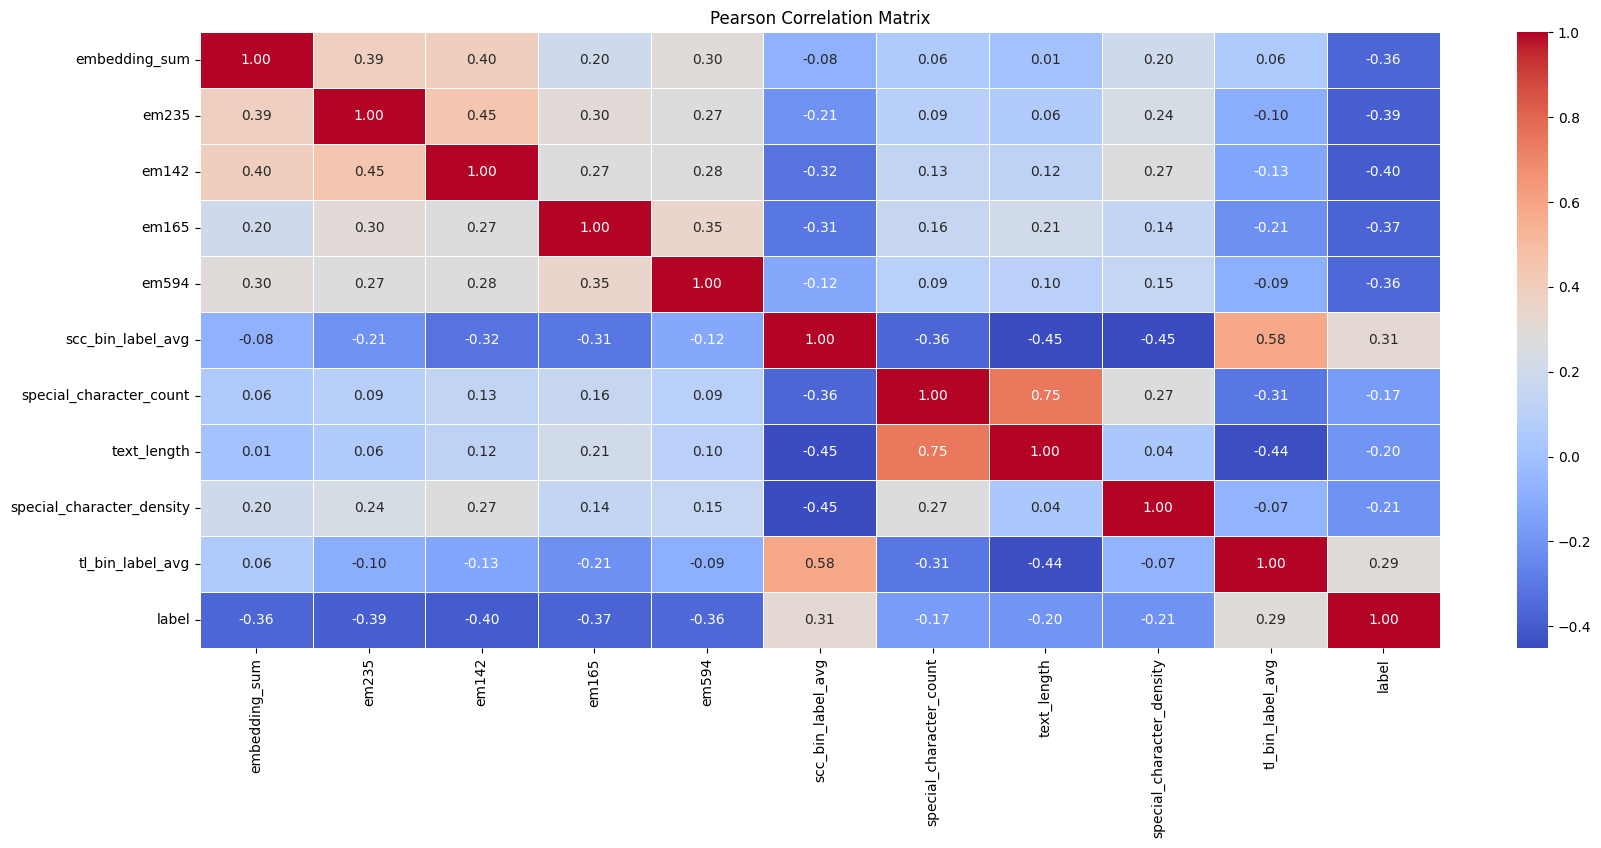

In [147]:
X_train_mini_with_label = X_train_mini.copy()
X_train_mini_with_label['label'] = y_train
correlation_matrix = X_train_mini_with_label.corr(method='pearson')

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.show()

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rfc = RandomForestClassifier(max_depth=5,n_estimators=500, random_state=42)

rfc.fit(X_train_mini, y_train)

y_pred = rfc.predict(X_dev_mini)


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.7484
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      2500
           1       0.81      0.65      0.72      2500

    accuracy                           0.75      5000
   macro avg       0.76      0.75      0.75      5000
weighted avg       0.76      0.75      0.75      5000



In [149]:
from sklearn.metrics import confusion_matrix,classification_report

print(confusion_matrix(dev_df['label'],y_pred))

[[2113  387]
 [ 871 1629]]


Feature ranking:
2. em235 (0.17496870697099468)
3. em142 (0.1623856829918899)
5. em594 (0.12954724725885108)
4. em165 (0.12193845606911505)
1. embedding_sum (0.09829878525842096)
8. text_length (0.09803827671521996)
9. special_character_density (0.0671868629650216)
7. special_character_count (0.06594993542306055)
10. tl_bin_label_avg (0.05373557829836652)
6. scc_bin_label_avg (0.027950468049059648)


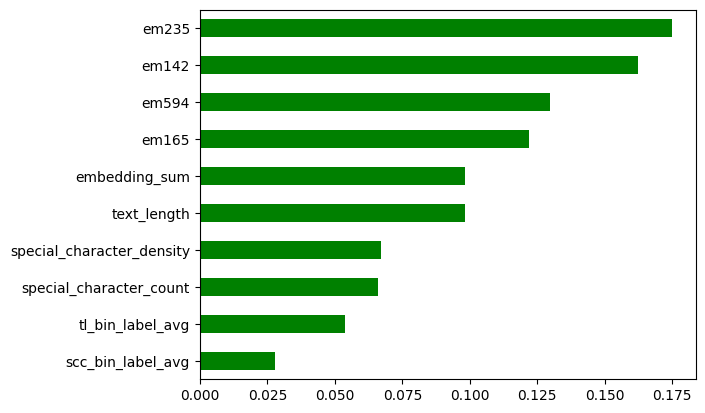

In [150]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=X_train[feature].columns)
feat_importances.nsmallest(len(feature)).plot(kind='barh',color='g')
plt.show()

# Final model : Random Forest Classfier with Structural, Embedding and T5 based features

In [158]:
req_col=[
'embedding_sum',
'scc_bin_label_avg',
'special_character_count',
"text_length",
"special_character_density",
"tl_bin_label_avg" ,
'sum_logprobs',
'meanp',
'stdp',
'entropyp',
'kurtosisp',
'skewnessp',
'perplexity'
          ]

In [156]:
train_embeddings_df = pd.DataFrame(train_embeddings)

embedding_column_names = ['em' + str(i+1) for i in range(train_embeddings_df.shape[1])]
train_embeddings_df.columns = embedding_column_names

X_train = pd.concat([train_df[req_col], train_embeddings_df], axis=1)

In [157]:
dev_embeddings_df = pd.DataFrame(dev_embeddings)

embedding_column_names = ['em' + str(i+1) for i in range(dev_embeddings_df.shape[1])]
dev_embeddings_df.columns = embedding_column_names

X_dev = pd.concat([dev_df[req_col], dev_embeddings_df], axis=1)

In [159]:
final_feature=[
 'embedding_sum',
 'em235',
 'em142',
 'em165',
 'em594',
 'scc_bin_label_avg',
 'special_character_count',
"text_length",
"special_character_density",
"tl_bin_label_avg" ,
'sum_logprobs',
'meanp',
'stdp',
'entropyp',
'kurtosisp',
'skewnessp',
'perplexity'

          ]
len(final_feature)

17

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

y_train = train_df['label']
y_dev = dev_df['label']


rfc = RandomForestClassifier(max_depth=9,n_estimators=500, random_state=42)

rfc.fit(X_train[final_feature], y_train)

y_pred = rfc.predict(X_dev[final_feature])


accuracy = accuracy_score(y_dev, y_pred)
report = classification_report(y_dev, y_pred)

print(f"Accuracy on development data: {accuracy}")
print(report)

Accuracy on development data: 0.762
              precision    recall  f1-score   support

           0       0.71      0.87      0.79      2500
           1       0.84      0.65      0.73      2500

    accuracy                           0.76      5000
   macro avg       0.78      0.76      0.76      5000
weighted avg       0.78      0.76      0.76      5000



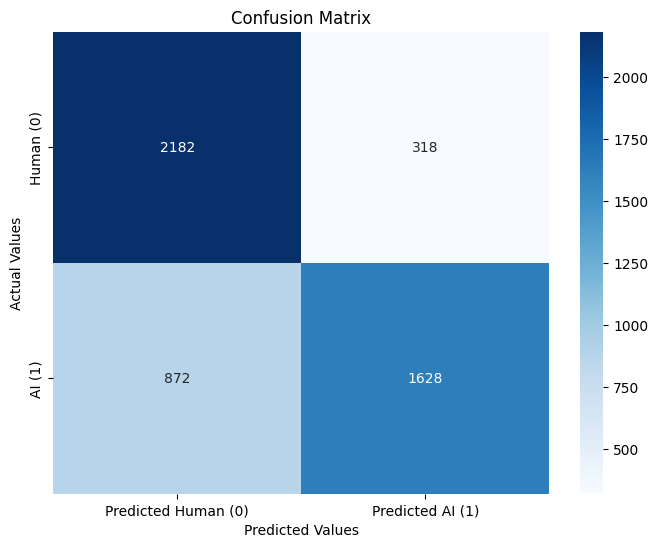

In [168]:
cm = confusion_matrix(dev_df['label'], y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['Human (0)', 'AI (1)'],
                     columns = ['Predicted Human (0)', 'Predicted AI (1)'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Feature ranking:
2. em235 (0.15178546252072345)
3. em142 (0.12615360886391208)
5. em594 (0.11399761040862104)
1. embedding_sum (0.11004673254110887)
4. em165 (0.108171498624154)
8. text_length (0.09660178706151461)
9. special_characters_density (0.06617222117151138)
7. special_characters_count (0.06330242362741077)
10. tl_bin_label_avg (0.054664383404905516)
6. scc_bin_label_avg (0.031068384441010503)
11. sum_logprobs (0.017492597117707294)
14. entropyp (0.014322553617659103)
17. perplexity (0.011824860576105725)
12. meanp (0.011455472305465694)
13. stdp (0.008549090616102574)
15. kurtosisp (0.0075408244223159875)
16. skewnessp (0.006850488679771501)


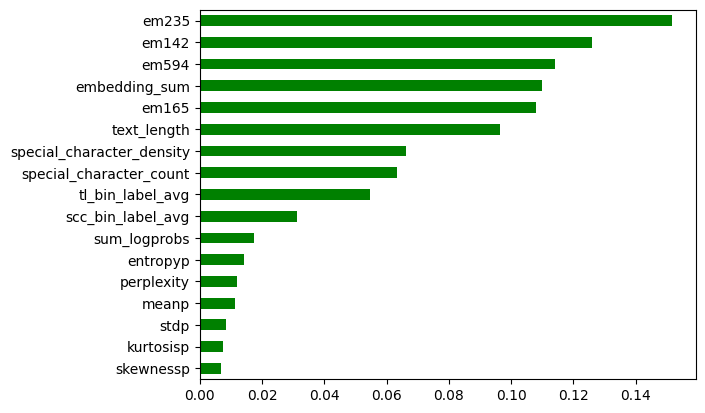

In [169]:
print("Feature ranking:")
importance = rfc.feature_importances_
indices = np.argsort(importance)[::-1]
for f in indices:
    print(f"{f + 1}. {feature[f]} ({importance[f]})")
feat_importances = pd.Series(rfc.feature_importances_, index=X_train[final_feature].columns)
feat_importances.nsmallest(len(final_feature)).plot(kind='barh',color='g')
plt.show()

# Evaluation

In [164]:
def write_predictions(dev_df, predictions, file_path):
    pred_df = pd.DataFrame({'id': dev_df['id'], 'label': predictions})
    pred_df.to_json(file_path, orient='records', lines=True)

prediction_file_path = '/content/drive/MyDrive/subtaskA/mono_pred/rfc_results_file_762.jsonl'
write_predictions(dev_df, y_pred, prediction_file_path)

In [ ]:
# gold_labels_df = dev_df[['id', 'label']]

# gold_labels_path = '/content/drive/MyDrive/subtaskA/mono_pred/gold_labels.jsonl'

# gold_labels_df.to_json(gold_labels_path, orient='records', lines=True)

In [165]:
!python3 "/content/drive/MyDrive/subtaskA/format_checker/format_checker.py" --pred_files_path="/content/drive/MyDrive/subtaskA/mono_pred/rfc_results_file_762.jsonl"

INFO : Subtask A and B. Checking files: ['/content/drive/MyDrive/subtaskA/mono_pred/rfc_results_file_762.jsonl']
INFO : Subtask A and B. Checking file: ['/content/drive/MyDrive/subtaskA/mono_pred/rfc_results_file_762.jsonl']. Result: Format is correct


In [166]:
!python3 "/content/drive/MyDrive/subtaskA/scorer.py" --gold_file_path='/content/drive/MyDrive/subtaskA/mono_pred/gold_labels.jsonl' --pred_file_path="/content/drive/MyDrive/subtaskA/mono_pred/rfc_results_file_762.jsonl"

INFO : Prediction file format is correct
INFO : macro-F1=0.75904	micro-F1=0.76200	accuracy=0.76200
